In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [9]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(10, 10)) for i in range(10)])
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [12]:
train(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.633755
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.679624
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.333911
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.347658
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.458653
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.580380
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.308873
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.195133
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.375889
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.282849


In [13]:
test()


Test set: Average loss: 0.3331, Accuracy: 9077/10000 (91%)



# Weight visualization

In [14]:
for m in network.modules():
  if isinstance(m, nn.Linear):
    weight = m.weight.data

weight.shape

torch.Size([10, 784])

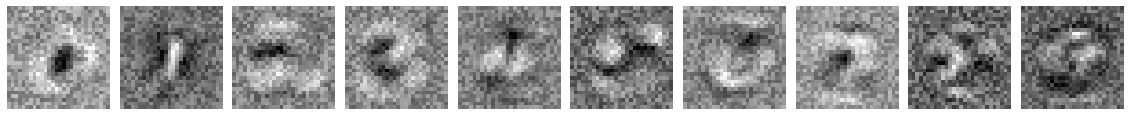

In [15]:
def plot_weights(weight):
  num_kernels = weight.shape[0]
  num_rows = 1
  fig = plt.figure(figsize=(10*2, num_rows*2))
  for i in range(weight.shape[0]):
    ax1 = fig.add_subplot(num_rows, 10, i+1)
    ax1.imshow(weight[i].reshape(28, 28), cmap="gray")
    ax1.axis("off")
  
  plt.subplots_adjust(wspace=0.1, hspace=0.1)

plot_weights(weight)

# Limiting train examples to 50

In [16]:
## limiting train examples to 50

def train_50():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data_50 = data[:50]
    target_50 = target[:50]
    data_50, target_50 = Variable(data_50), Variable(target_50)
    optimizer.zero_grad()
    output = network(data_50)
    loss = F.cross_entropy(output, target_50)
    loss.backward()
    optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                1, (batch_idx+1) * len(data_50), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    break
    


In [17]:
network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [18]:
train_50()

Train Epoch: 1 [50/60000 (0%)]	Loss: 2.434991


In [19]:
test()


Test set: Average loss: 2.2894, Accuracy: 1643/10000 (16%)

